### Import libraries and datasets

In [1]:
## Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
# import seaborn as sns
# import random

## Import datasets
ratings_original = pd.read_csv('../datasets/gb10k_ratings.csv')
books_original = pd.read_csv('../datasets/gb10k_books.csv')
tags_original = pd.read_csv('../datasets/gb10k_tags.csv')
books_tags_original = pd.read_csv('../datasets/gb10k_book_tags.csv')

### Ratings table inspection

In [2]:
ratings = ratings_original.copy()

In [3]:
##First insights on the quality of the data
print('')
print('Explore table headers:')
print('')
print(ratings.head())
print('________________________')
print('')
print('Explore table types:')
print('')
print(ratings.info())
print('________________________')
print('')
print('Explore table missing values:')
print('')
print(ratings.isna().sum())
print('________________________')


Explore table headers:

   user_id  book_id  rating
0        1      258       5
1        2     4081       4
2        2      260       5
3        2     9296       5
4        2     2318       3
________________________

Explore table types:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5976479 entries, 0 to 5976478
Data columns (total 3 columns):
user_id    int64
book_id    int64
rating     int64
dtypes: int64(3)
memory usage: 136.8 MB
None
________________________

Explore table missing values:

user_id    0
book_id    0
rating     0
dtype: int64
________________________


In [4]:
##Check number of unique users
print('Number of unique users:', len(ratings.user_id.unique()))

Number of unique users: 53424


In [5]:
## Match ratings with book title
books_title = books_original[['book_id', 'title']]
ratings_with_titles = pd.merge(ratings, books_title, on='book_id')

In [6]:
ratings_with_titles.head()

,user_id,book_id,rating,title
0,1,258,5,The Shadow of the Wind (The Cemetery of Forgot...
1,11,258,3,The Shadow of the Wind (The Cemetery of Forgot...
2,143,258,4,The Shadow of the Wind (The Cemetery of Forgot...
3,242,258,5,The Shadow of the Wind (The Cemetery of Forgot...
4,325,258,4,The Shadow of the Wind (The Cemetery of Forgot...


In [7]:
print('Length of original book dataset:', len(books_title))
print('Length of original ratings dataset:', len(ratings))
print('Length of merged book-ratings dataset:', len(ratings_with_titles))
print('Unique book titles in merged book-ratings dataset:', len(ratings_with_titles.title.unique()))
print('Unique book ids in merged book-ratings dataset:', len(ratings_with_titles.book_id.unique()))

Length of original book dataset: 10000
Length of original ratings dataset: 5976479
Length of merged book-ratings dataset: 5976479
Unique book titles in merged book-ratings dataset: 9964
Unique book ids in merged book-ratings dataset: 10000


In [8]:
ratings_with_titles.isna().sum()

user_id    0
book_id    0
rating     0
title      0
dtype: int64

In [9]:
## There are no missing values. The fact that the unique number of titles is below 10000 is caused by several books
## having the same title
books_title.title.value_counts()

Selected Poems                                                    4
Stone Soup                                                        3
Between the Lines (Between the Lines, #1)                         2
Bambi                                                             2
The Complete Stories and Poems                                    2
                                                                 ..
Dibs in Search of Self                                            1
Beyond Band of Brothers: The War Memoirs of Major Dick Winters    1
Tribulation Force (Left Behind, #2)                               1
A Place Called Here                                               1
Scoop                                                             1
Name: title, Length: 9964, dtype: int64

### Books table inspection

In [10]:
books = books_original.copy()

In [11]:
##First insights on the quality of the data
print('')
print('Lenght of the dataset:', books.shape[0])
print('________________________')
print('')
print('Explore table headers:')
print('')
print(books.head())
print('________________________')
print('')
print('Explore table types:')
print('')
print(books.dtypes)
print('________________________')
print('')
print('Explore table missing values:')
print('')
print(books.isna().sum())
print('________________________')


Lenght of the dataset: 10000
________________________

Explore table headers:

   book_id  goodreads_book_id  best_book_id  work_id  books_count       isbn  \
0        1            2767052       2767052  2792775          272  439023483   
1        2                  3             3  4640799          491  439554934   
2        3              41865         41865  3212258          226  316015849   
3        4               2657          2657  3275794          487   61120081   
4        5               4671          4671   245494         1356  743273567   

         isbn13                      authors  original_publication_year  \
0  9.780439e+12              Suzanne Collins                     2008.0   
1  9.780440e+12  J.K. Rowling, Mary GrandPré                     1997.0   
2  9.780316e+12              Stephenie Meyer                     2005.0   
3  9.780061e+12                   Harper Lee                     1960.0   
4  9.780743e+12          F. Scott Fitzgerald                    

*Note by the author of the dataset: 'Each book may have many editions. goodreads_book_id and best_book_id generally point to the most popular edition of a given book, while goodreads work_id refers to the book in the abstract sense.' In ratings.csv all different editions are aggregated.*

In [12]:
#Remove ids not needed:
books.drop(columns = ['best_book_id', 'work_id'], inplace=True)

#Remove features with a lot of missing values (as they will not be used in the analysis):
books.drop(columns = ['isbn', 'isbn13', 'original_title', 'language_code'], inplace=True)

#Remove count features and URLs, unrelated to this analysis:
books.drop(columns = ['books_count', 'ratings_count', 'work_text_reviews_count', 'image_url', 'small_image_url'], inplace=True)

In [13]:
## Replace missing publication years with 0 and transform to int
books.loc[(books.original_publication_year.isna()), 'original_publication_year'] = 0
books['original_publication_year'] = books['original_publication_year'].astype('int64')

In [14]:
## Separate the information on the title column, which includes the 'series' of the book when it belongs to a saga

## Get the title of the book
def title_split_book_name(string):
    split = string.split(' (')
    if len(split) > 1:
        split[1] = split[1].split(',')[0]
        return split[0]
    else:
        return string
    
## Get the series of the book. If no series exists, it returns an empty string.
def title_split_book_series(string):
    split = string.split(' (')
    if len(split) > 1:
        split[1] = split[1].split(',')[0]
        return split[1]
    else:
        return ''
    
## Apply both functions to the title column. Create 2 new columns and delete the original one.
books['book_title'] = books['title'].apply(title_split_book_name)
books['book_series'] = books['title'].apply(title_split_book_series)
books.drop(columns='title', inplace=True)

In [15]:
## Check accuracy of the average rating in the dataset. 
ratings_check = books.drop(columns= ['book_id', 'goodreads_book_id', 'authors', 'original_publication_year', 'book_title', 'book_series'])
ratings_check['my_avg'] = ((ratings_check['ratings_1']*1) + (ratings_check['ratings_2']*2) + (ratings_check['ratings_3']*3) + (ratings_check['ratings_4']*4) + (ratings_check['ratings_5']*5)) / ratings_check['work_ratings_count']
ratings_check
## The column is correct, so further calculations can be based on it. 


,average_rating,work_ratings_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,my_avg
0,4.34,4942365,66715,127936,560092,1481305,2706317,4.341984
1,4.44,4800065,75504,101676,455024,1156318,3011543,4.443047
2,3.57,3916824,456191,436802,793319,875073,1355439,3.571067
3,4.25,3340896,60427,117415,446835,1001952,1714267,4.254818
4,3.89,2773745,86236,197621,606158,936012,947718,3.887376
...,...,...,...,...,...,...,...,...
9995,4.09,18856,105,575,3538,7860,6778,4.094134
9996,4.25,12952,303,551,1737,3389,6972,4.248919
9997,4.35,10733,11,111,1191,4240,5180,4.347899
9998,3.65,11994,275,1002,3765,4577,2375,3.648241


In [16]:
books = books[['book_id', 'goodreads_book_id', 'book_title', 'book_series', 'authors', 'original_publication_year', 'average_rating', 'work_ratings_count', 'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5']]
books.head()

,book_id,goodreads_book_id,book_title,book_series,authors,original_publication_year,average_rating,work_ratings_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5
0,1,2767052,The Hunger Games,The Hunger Games,Suzanne Collins,2008,4.34,4942365,66715,127936,560092,1481305,2706317
1,2,3,Harry Potter and the Sorcerer's Stone,Harry Potter,"J.K. Rowling, Mary GrandPré",1997,4.44,4800065,75504,101676,455024,1156318,3011543
2,3,41865,Twilight,Twilight,Stephenie Meyer,2005,3.57,3916824,456191,436802,793319,875073,1355439
3,4,2657,To Kill a Mockingbird,,Harper Lee,1960,4.25,3340896,60427,117415,446835,1001952,1714267
4,5,4671,The Great Gatsby,,F. Scott Fitzgerald,1925,3.89,2773745,86236,197621,606158,936012,947718


In [17]:
##Export to CSV
books.to_csv('../datasets/clean_books.csv')

### Tags table inspection

In [18]:
tags = tags_original.copy()

In [19]:
##First insights on the quality of the data
print('')
print('Explore table headers:')
print('')
print(tags.head())
print('________________________')
print('')
print('Explore table types:')
print('')
print(tags.dtypes)
print('________________________')
print('')
print('Explore table missing values:')
print('')
print(tags.isna().sum())
print('________________________')


Explore table headers:

   tag_id tag_name
0       0        -
1       1     --1-
2       2    --10-
3       3    --12-
4       4   --122-
________________________

Explore table types:

tag_id       int64
tag_name    object
dtype: object
________________________

Explore table missing values:

tag_id      0
tag_name    0
dtype: int64
________________________


In [20]:
## Check that all elements in the table are unique values
print('')
print('There are', len(tags), 'records in the table')
print('There are', len(tags.tag_name.unique()), 'unique tags in the table')


There are 34252 records in the table
There are 34252 unique tags in the table


In [21]:
## Merge the tags with the books to evaluate tags distribution
books_tags = books_tags_original.copy()
books_with_tags = pd.merge(books_tags, tags, on=['tag_id'])
books_per_tag = books_with_tags.groupby(['tag_id', 'tag_name'], as_index=False).count().drop(columns=['count']).rename(columns={'goodreads_book_id':'number_of_books'}).sort_values(by=['number_of_books'], ascending=False).reset_index(drop=True)
books_per_tag.describe()

,tag_id,number_of_books
count,34252.000000,34252.000000
mean,17125.500000,29.192806
std,9887.845047,277.254715
min,0.000000,1.000000
25%,8562.750000,1.000000
50%,17125.500000,1.000000
75%,25688.250000,5.000000
max,34251.000000,9983.000000


<Figure size 720x288 with 0 Axes>

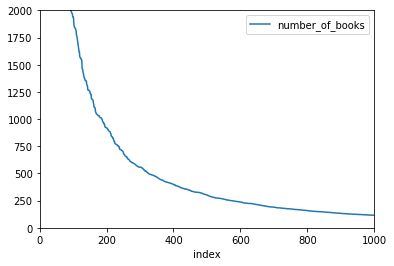

In [22]:
## Plot tags distribution
plt.figure(figsize=(10,4))
books_per_tag.reset_index().plot(x='index', y='number_of_books')
plt.ylim(0,2000)
plt.xlim(0,1000)
plt.show()

In [23]:
##Explore the optimal amount of tags to keep, considering the elbow of the previous plot
number_of_tagged_books = [1500, 1250, 1000, 750, 500, 250]

for i in number_of_tagged_books:
    reduced_books_per_tag = books_per_tag.copy()
    reduced_books_per_tag = reduced_books_per_tag[reduced_books_per_tag.number_of_books > i]
    list_of_tags = reduced_books_per_tag.tag_id.unique().tolist()
    books_with_tags_reduced = books_with_tags.copy()
    books_with_tags_reduced = books_with_tags_reduced[books_with_tags_reduced.tag_id.isin(list_of_tags)]
    tags_per_book = books_with_tags_reduced.groupby(['goodreads_book_id'], as_index=False).count().drop(columns=['count', 'tag_name']).rename(columns={'tag_id':'number_of_tags'}).sort_values(by=['number_of_tags'], ascending=True).reset_index(drop=True)
    print('If we keep the most used', len(list_of_tags), 'tags, the less qualified book will have', tags_per_book.iloc[0, 1], 'related tags.')

If we keep the most used 127 tags, the less qualified book will have 10 related tags.
If we keep the most used 151 tags, the less qualified book will have 11 related tags.
If we keep the most used 186 tags, the less qualified book will have 12 related tags.
If we keep the most used 237 tags, the less qualified book will have 14 related tags.
If we keep the most used 325 tags, the less qualified book will have 17 related tags.
If we keep the most used 572 tags, the less qualified book will have 17 related tags.


In [24]:
##Export tags to review
tags_to_review = books_per_tag.iloc[:150,].copy()
tags_to_review = tags_to_review.drop(columns='number_of_books')
tags_to_review.to_csv('../datasets/work_datasets/tags_to_review.csv')

In [25]:
##Import tags reviewed
tags_reviewed = pd.read_csv('../datasets/work_datasets/tags_reviewed.csv')
tags_reviewed.drop(columns=['Unnamed: 0'], inplace=True)
tags_reviewed

,tag_id,old_tag_name,new_tag_name,tag_class
0,30574,to-read,to-read,book_status
1,11557,favorites,favorites,book_status
2,22743,owned,owned,book_status
3,5207,books-i-own,owned,book_status
4,8717,currently-reading,reading,book_status
...,...,...,...,...
145,7852,coming-of-age,coming-of-age,genre
146,6888,children-s,children,genre
147,17124,kids,children,genre
148,22333,on-kindle,kindle,type


In [26]:
##Replace tags name in the original dataframe. Change all the other tags name to tag_name 'other' and tag_class 'general'
books_with_new_tags = books_with_tags.set_index('tag_id').join(tags_reviewed.set_index('tag_id'), on='tag_id', how='left').reset_index()
books_with_new_tags['new_tag_name'] = books_with_new_tags.new_tag_name.fillna('other')
books_with_new_tags['tag_class'] = books_with_new_tags.tag_class.fillna('general')
books_with_new_tags.drop(columns=['tag_name', 'old_tag_name', 'tag_id'], inplace=True)

In [27]:
books_with_new_tags.head()

,goodreads_book_id,count,new_tag_name,tag_class
0,1,167697,to-read,book_status
1,2,24549,to-read,book_status
2,3,496107,to-read,book_status
3,5,11909,to-read,book_status
4,6,298,to-read,book_status


In [28]:
##Export to CSV
books_with_new_tags.to_csv('../datasets/clean_tags_books.csv')

### Some data insigths

In [29]:
##Get some insights on the users
ratings_by_user = ratings.groupby(['user_id'], as_index=False).count()
ratings_by_user = ratings_by_user.drop(columns=['rating']).rename(columns={'book_id':'number_of_ratings'}).sort_values(by=['number_of_ratings'], ascending=False)
ratings_by_user.number_of_ratings.describe()

count    53424.000000
mean       111.868804
std         26.071224
min         19.000000
25%         96.000000
50%        111.000000
75%        128.000000
max        200.000000
Name: number_of_ratings, dtype: float64

In [30]:
print('')
print('Number of users:', len(ratings_by_user))
print('Maximum amount of ratings per users:', ratings_by_user.number_of_ratings.describe()['max'])
print('Average amount of ratings per user:', ratings_by_user.number_of_ratings.describe()['mean'])
print('Minimum amount of ratings per users:', ratings_by_user.number_of_ratings.describe()['min'])
print('Number of users with more than 100 reviews:', len(ratings_by_user[ratings_by_user.number_of_ratings > 100]))
print('Number of users with more than 50 reviews:', len(ratings_by_user[ratings_by_user.number_of_ratings > 50]))
print('')


Number of users: 53424
Maximum amount of ratings per users: 200.0
Average amount of ratings per user: 111.86880428271938
Minimum amount of ratings per users: 19.0
Number of users with more than 100 reviews: 36199
Number of users with more than 50 reviews: 52485



In [31]:
##Get some insights on the ratings
ratings_by_book = ratings.groupby(['book_id'], as_index=False).count()
ratings_by_book = ratings_by_book.drop(columns=['rating']).rename(columns={'user_id':'number_of_ratings'}).sort_values(by=['number_of_ratings'], ascending=False)
ratings_by_book.number_of_ratings.describe()

count    10000.000000
mean       597.647900
std       1267.289788
min          8.000000
25%        155.000000
50%        248.000000
75%        503.000000
max      22806.000000
Name: number_of_ratings, dtype: float64

In [32]:
print('')
print('Number of rated books:', len(ratings_by_book))
print('Maximum amount of ratings per book:', ratings_by_book.number_of_ratings.describe()['max'])
print('Average amount of ratings per book:', ratings_by_book.number_of_ratings.describe()['mean'])
print('Minimum amount of ratings per book:', ratings_by_book.number_of_ratings.describe()['min'])
print('Number of books with more than 100 reviews:', len(ratings_by_book[ratings_by_book.number_of_ratings > 100]))
print('Number of books with more than 50 reviews:', len(ratings_by_book[ratings_by_book.number_of_ratings > 50]))
print('')


Number of rated books: 10000
Maximum amount of ratings per book: 22806.0
Average amount of ratings per book: 597.6479
Minimum amount of ratings per book: 8.0
Number of books with more than 100 reviews: 9484
Number of books with more than 50 reviews: 9990



In [33]:
## Check the rating distribution
ratings_distribution = ratings.groupby(['rating'], as_index=False).count()
ratings_distribution = ratings_distribution.drop(columns=['book_id']).rename(columns={'user_id':'number_of_ratings'}).sort_values(by=['number_of_ratings'], ascending=False)
ratings_distribution['percentage'] = ratings_distribution.number_of_ratings/ratings_distribution.number_of_ratings.sum(axis = 0)
ratings_distribution

,rating,number_of_ratings,percentage
3,4,2139018,0.357906
4,5,1983093,0.331816
2,3,1370916,0.229385
1,2,359257,0.060112
0,1,124195,0.020781



Number of ratings: 5976479
5-star ratings: 33.181627510110886 %
4-star ratings: 35.790605137238835 %
3-star ratings: 22.938522832590895 %
2-star ratings: 6.011181500010291 %
1-star ratings: 2.078063020049096 %



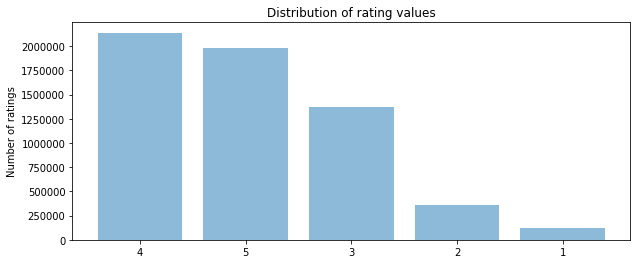

In [34]:
print('')
print('Number of ratings:', ratings_distribution.number_of_ratings.sum(axis = 0))
print('5-star ratings:', (ratings_distribution.loc[(ratings_distribution.rating == 5), 'percentage'].values[0])*100, '%')
print('4-star ratings:', (ratings_distribution.loc[(ratings_distribution.rating == 4), 'percentage'].values[0])*100, '%')
print('3-star ratings:', (ratings_distribution.loc[(ratings_distribution.rating == 3), 'percentage'].values[0])*100, '%')
print('2-star ratings:', (ratings_distribution.loc[(ratings_distribution.rating == 2), 'percentage'].values[0])*100, '%')
print('1-star ratings:', (ratings_distribution.loc[(ratings_distribution.rating == 1), 'percentage'].values[0])*100, '%')
print('')

plt.figure(figsize=(10,4))

x = ratings_distribution.rating
y_pos = np.arange(len(x))
y = ratings_distribution.number_of_ratings

plt.bar(y_pos, y, align='center', alpha=0.5)
plt.xticks(y_pos, x)
plt.ylabel('Number of ratings')
plt.title('Distribution of rating values')
plt.show()